In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

## Import data

In [2]:
df = pd.read_csv('data.csv')
df.head()

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118


In [3]:
df.tail()

,Period,Sales
7,8,10717
8,9,7825
9,10,9693
10,11,15177
11,12,10990


## Visualizing Data

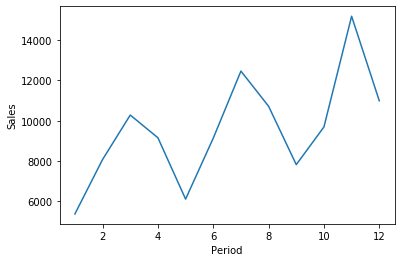

In [4]:
sns.lineplot(df['Period'], df['Sales'])

### Interpretation
- Assume that period is month
- Divide 12 months to 3 periods, each periods consume 3 months
- Sales increase until the third month then decrease
- Each period, third month is the highest sales.

## Predict sales (without seasonality)

### Moving average

In [5]:
from statsmodels.tsa.arima_model import ARIMA

#### Predict Sales

In [6]:
model = ARIMA(df['Sales'], order=(1, 0, 0)).fit(disp=False)
df_predict = pd.DataFrame(pd.Series(model.predict(12, 15)), columns=['Sales'])
df_predict['Period'] = df_predict.apply(lambda x: x.name + 1, axis=1)
df_predict = df_predict.reindex(columns=['Period', 'Sales'])
df_predict

,Period,Sales
12,13,9881.261756
13,14,9604.351785
14,15,9535.192871
15,16,9517.920270


#### Evaluate Model

In [7]:
from sklearn.metrics import mean_squared_error

In [8]:
df_test = pd.read_csv('actual.csv')
mse = mean_squared_error(df_test['Sales'], df_predict['Sales'])
print(np.sqrt(mse))

3671.939059252289


As we can see, the error is supper high. Let us explore other options.

### Exponential Smoothing

In [9]:
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing

#### Predict Sales

In [10]:
model = ExponentialSmoothing(df['Sales'].astype('double')).fit()
df_predict = pd.DataFrame(pd.Series(model.forecast(4), name='Sales'))
df_predict['Period'] = df_predict.apply(lambda x: x.name + 1, axis=1)
df_predict = df_predict.reindex(columns=['Period', 'Sales'])
df_predict

,Period,Sales
12,13,10952.074333
13,14,10952.074333
14,15,10952.074333
15,16,10952.074333


The prediction isn't very good. Let's explore seasonality

## Predict sales (with seasonality)

### Compute seasonal indices

In [11]:
df_new = pd.DataFrame(columns=['Period', 'Sales', 'Seasonal Index'])
for it in range(len(df)):
    df_season = df[df['Period'] % 4 == it].copy()
    df_season['Seasonal Index'] = df_season['Sales'].mean()
    df_new = df_new.append(df_season)
    
df_new = df_new.sort_values(by=['Period'])

### Compute de-seasonalized version

In [12]:
df_new['Sales'] /= df_new['Seasonal Index']
df_new

,Period,Sales,Seasonal Index
0,1,0.835722,6442.333333
1,2,0.900791,8971.000000
2,3,0.813471,12639.666667
3,4,0.889998,10287.666667
4,5,0.949656,6442.333333
5,6,1.01873,8971.000000
6,7,0.985785,12639.666667
7,8,1.04173,10287.666667
8,9,1.21462,6442.333333
9,10,1.08048,8971.000000


### Apply linear regression

In [13]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(df_new['Period'].values.reshape(-1, 1), df_new['Sales'].values.reshape(-1, 1))
new_predict = model.predict(pd.Series([13, 14, 15, 16]).values.reshape(-1, 1))

### Compute seasonal forecast

In [14]:
df_new_predict = pd.DataFrame([pd.Series([13, 14, 15, 16]), df_new['Seasonal Index'][0: 4] * pd.Series(new_predict.flatten())], index=['Period', 'Sales']).transpose()
df_new_predict['Period'] = df_new_predict['Period'].astype(int)
df_new_predict

,Period,Sales
0,13,7759.069761
1,14,11086.652922
2,15,16017.956052
3,16,13360.809823


### Evaluate the model

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

print(r2_score(df_test['Sales'].to_numpy(), df_new_predict['Sales'].to_numpy()))


0.9819810535561102
